In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize

In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [ ]:
df_train = pd.read_csv("/content/twitter_training.csv")
df_valid = pd.read_csv("/content/twitter_validation.csv")

In [ ]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
df_train.columns

Index(['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,'], dtype='object')

In [ ]:
df_train.columns=['id','information','status','comment']
df_train.head()

,id,information,status,comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
df_valid.columns=['id','information','status','comment']
df_valid.head()

,id,information,status,comment
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60954 entries, 0 to 60953
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           60954 non-null  int64 
 1   information  60954 non-null  object
 2   status       60954 non-null  object
 3   comment      60400 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           999 non-null    int64 
 1   information  999 non-null    object
 2   status       999 non-null    object
 3   comment      999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [ ]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 id               0
information      0
status           0
comment        554
dtype: int64


In [ ]:
df_train = df_train.dropna(subset=['comment'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60400 entries, 0 to 60953
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           60400 non-null  int64 
 1   information  60400 non-null  object
 2   status       60400 non-null  object
 3   comment      60400 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df_train["comment"] = df_train["comment"].str.lower()
df_valid["comment"] = df_valid["comment"].str.lower()

In [ ]:
"""
[@&]\S+ → @mention ve &labels
& → only &
http\S+|www\S+ → URL's
\d+ → Numbers
[^\w\s] → all Punctuations
\s+ → Fazla boşlukları temizler.
.str.strip() → Baştaki ve sondaki boşlukları kaldırır.
"""
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                         .str.replace(r"\s+", " ", regex=True) \
                                         .str.strip()

df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                         .str.replace(r"\s+", " ", regex=True) \
                                         .str.strip()

In [ ]:
nltk.download("stopwords")
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train["comment"] = df_train["comment"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df_valid["comment"] = df_valid["comment"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [ ]:
temp_df_train = pd.Series(" ".join(df_train["comment"]).split()).value_counts()
temp_df_valid = pd.Series(" ".join(df_valid["comment"]).split()).value_counts()

In [ ]:
temp_df_train

,count
game,6380
im,4222
like,4035
get,3186
one,2977
...,...
onlinego,1
mehtun,1
taurissan,1
gudan,1


In [ ]:
drop_train = temp_df_train[temp_df_train <= 1]
drop_valid = temp_df_valid[temp_df_valid <= 1]

In [ ]:
df_train["comment"] = df_train["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in drop_train))
df_valid["comment"] = df_valid["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in drop_valid))

In [ ]:
df_train.head(10)

,id,information,status,comment
0,2401,Borderlands,Positive,coming borders kill
1,2401,Borderlands,Positive,im getting borderlands kill
2,2401,Borderlands,Positive,im coming borderlands murder
3,2401,Borderlands,Positive,im getting borderlands murder
4,2401,Borderlands,Positive,im getting borderlands murder
5,2402,Borderlands,Positive,spent hours making something fun dont know hug...
6,2402,Borderlands,Positive,spent couple hours something fun dont know im ...
7,2402,Borderlands,Positive,spent hours something fun dont know im huge bo...
8,2402,Borderlands,Positive,spent hours making something fun dont know hug...
9,2402,Borderlands,Positive,spent hours making something fun dont know hug...


In [ ]:
#Count information per category
plot1=df_train.groupby(by=["information","status"]).count().reset_index()
plot1.head()

,information,status,id,comment
0,Amazon,Irrelevant,186,186
1,Amazon,Negative,575,575
2,Amazon,Neutral,1207,1207
3,Amazon,Positive,308,308
4,ApexLegends,Irrelevant,192,192


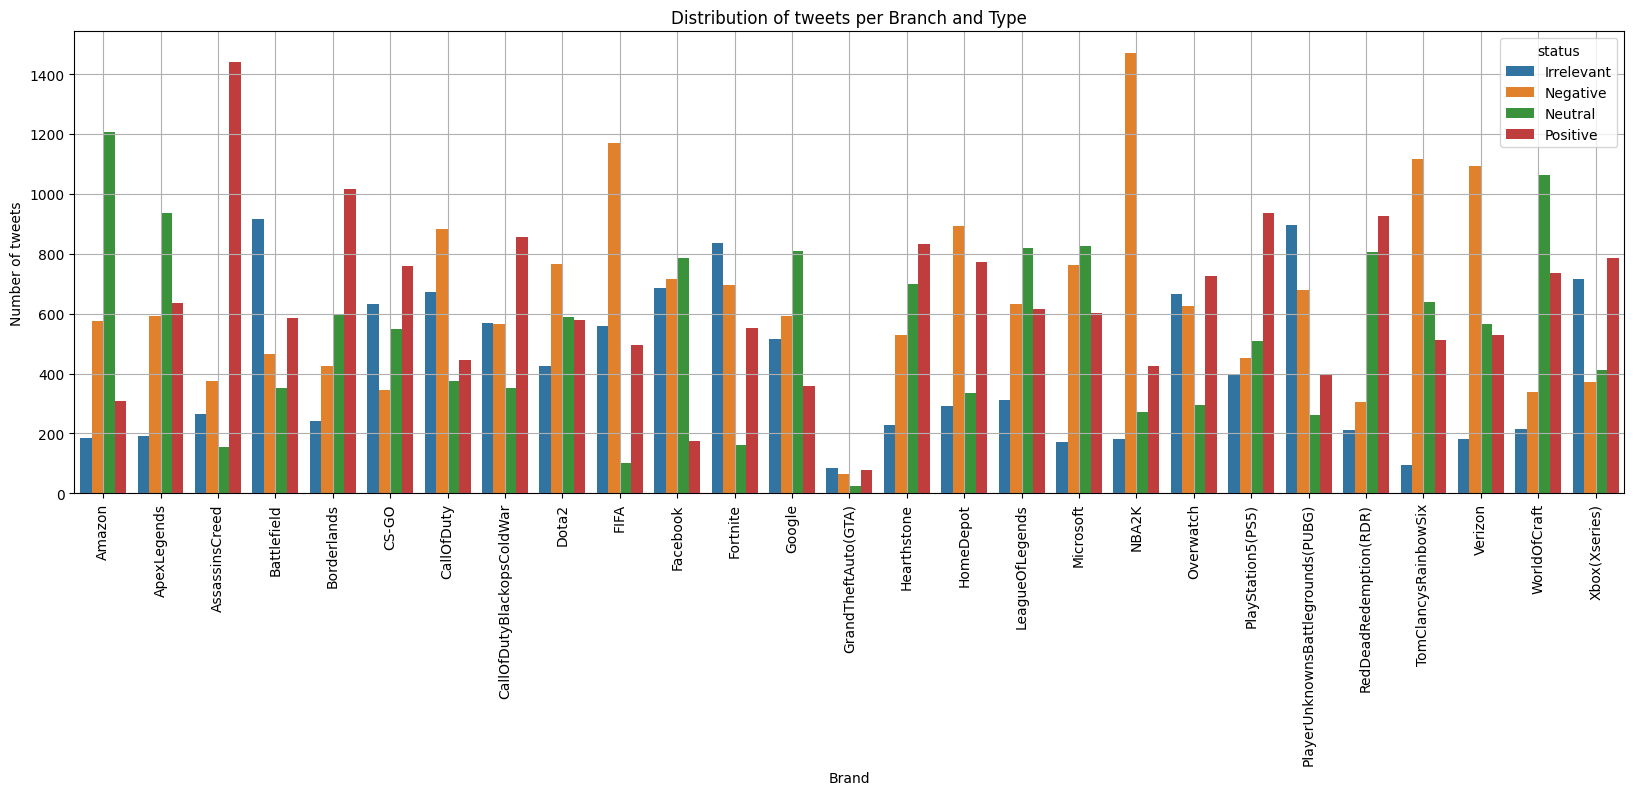

In [ ]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=plot1,x="information",y="id",hue="status")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

<ipython-input-26-6375d347c227>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df_train, palette='viridis')


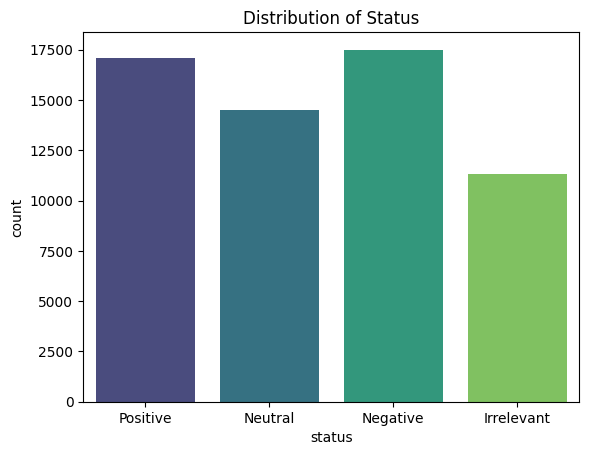

In [ ]:
# Sentiment distribution
sns.countplot(x='status', data=df_train, palette='viridis')
plt.title("Distribution of Status")
plt.show()

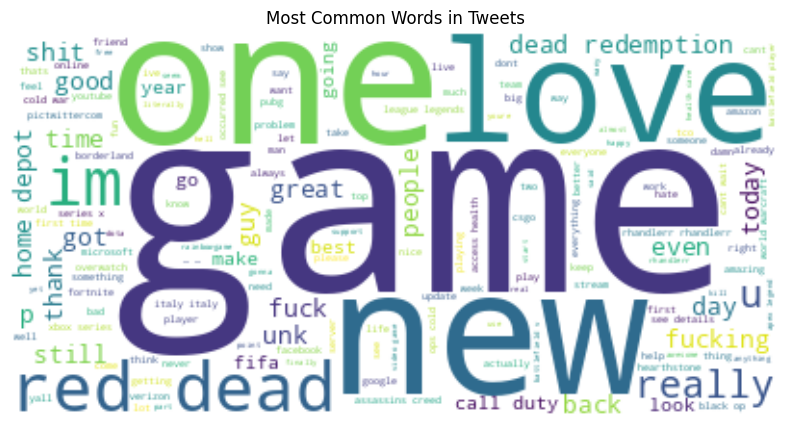

In [ ]:
# Wordcloud
text = " ".join(i for i in df_train.comment)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Words in Tweets")
plt.axis("off")
plt.show()

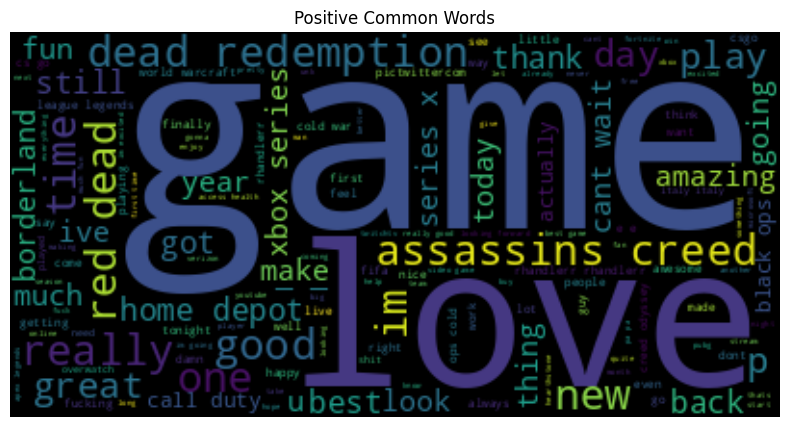

In [ ]:
# Wordcloud positive
# "Positive" filter
positive_comments = df_train[df_train["status"] == "Positive"]["comment"]

text_positive = ''.join(i for i in positive_comments)
wordcloud = WordCloud(background_color="black").generate(text_positive)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Positive Common Words")
plt.axis("off")
plt.show()

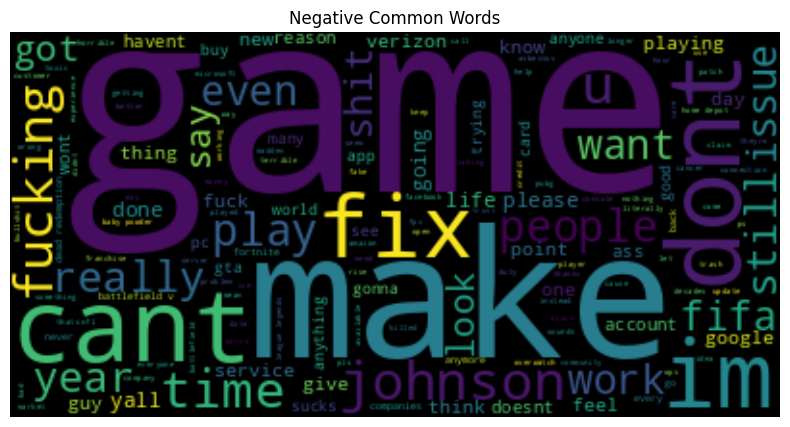

In [ ]:
# Wordcloud negative
# "Negative" filter
negative_comments = df_valid[df_valid["status"] == "Negative"]["comment"]

text_positive = ''.join(i for i in negative_comments)
wordcloud = WordCloud(background_color="black").generate(text_positive)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Negative Common Words")
plt.axis("off")
plt.show()

In [ ]:
!pip install nltk
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# ... (your existing code) ...

#Text splitting
tokens_text = [word_tokenize(str(word)) for word in df_train["comment"]]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Number of tokens:  22511


In [ ]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in df_train["comment"]]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  22511


In [ ]:
# Convert text to numerical features
vectorizer = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_train['comment'])
y = df_train['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a simple classifier
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification Report
Accuracy: 0.8875827814569537
              precision    recall  f1-score   support

  Irrelevant       0.95      0.83      0.88      2330
    Negative       0.90      0.91      0.90      3480
     Neutral       0.92      0.86      0.89      2872
    Positive       0.83      0.93      0.87      3398

    accuracy                           0.89     12080
   macro avg       0.90      0.88      0.89     12080
weighted avg       0.89      0.89      0.89     12080



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pickle
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

if __name__ == "__main__":
    # Save the model and vectorizer first if they haven't been saved yet
    # You need to train and save the model and vectorizer before loading them.
    # The code below trains the model and saves both the model and the vectorizer.

    # Convert text to numerical features
    vectorizer = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))
    X = vectorizer.fit_transform(df_train['comment'])
    y = df_train['status']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Train a simple classifier
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)

    # Save the model and vectorizer using joblib.dump
    joblib.dump(model, "logistic_regression_model.pkl")
    joblib.dump(vectorizer, "count_vectorizer.pkl")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

def load_model_and_vectorizer(model_path, vectorizer_path):
    # Load the model using joblib.load
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    return model, vectorizer

def predict_sentiment(text, model, vectorizer):
    processed_text = text.lower()
    processed_text = " ".join(word_tokenize(processed_text))
    X_new = vectorizer.transform([processed_text])
    prediction = model.predict(X_new)[0]
    return prediction

model_path = "logistic_regression_model.pkl"  # Change to actual path if necessary
vectorizer_path = "count_vectorizer.pkl"  # Change to actual path if necessary

model, vectorizer = load_model_and_vectorizer(model_path, vectorizer_path)
#new_text = input("Enter a sentence for sentiment analysis: ")
#sentiment = predict_sentiment(new_text, model, vectorizer)
#print(f"Predicted Sentiment: {sentiment}")

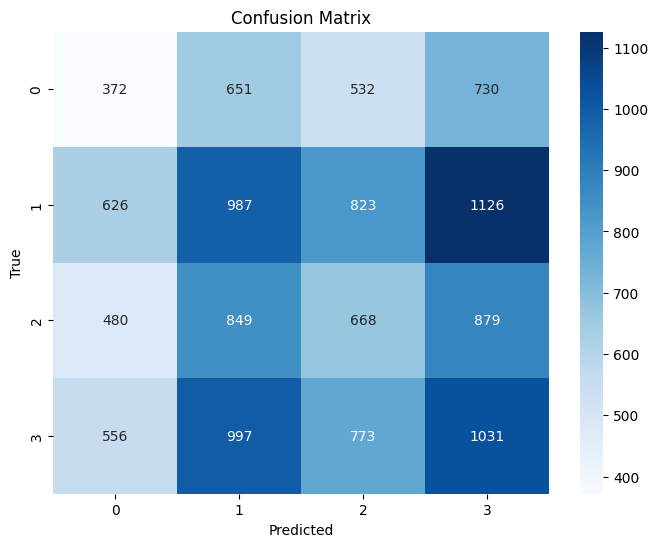

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()